# Tarea 4 - LTE opacities for a pure H atmosphere

We try to reproduce Figure 8.5 a, b, c, d from Gray, which show the wavelength-dependent continuous absorption coefficient $\kappa_\lambda$ for different temperatures $T$ and electron pressures $P_e$.  For simplicity, we consider only hydrogen, in the form of the neutral atom and the positive and negative ions.  Ion fractions and excitation of bound levels is calculated under the assumption of local thermodynamic equilibrium. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True)

/Users/will/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Set up the constants we need

In [2]:
import astropy.units as u
from astropy.constants import k_B, h, m_p, a0
from astropy.constants import c as light_speed
from astropy.table import Table, Column

We work with all energies in electron volts. We define the constants as regular floats because it doesn't seem possible to use `astropy.units` quantities with `@np.vectorize`d functions.

In [3]:
BOLTZMANN = k_B.to(u.eV/u.K).value
PLANCK = h.to(u.eV*u.s).value
RYDBERG = (1.0*u.Ry).to(u.eV).value
HMINUS_EION = (0.754*u.eV).value
BOHR_RADIUS = a0.cgs.value

print('BOLTZMANN =', BOLTZMANN, 'eV/K')
print('PLANCK =', PLANCK, 'eV.s')
print('RYDBERG =', RYDBERG, 'eV')
print('HMINUS_EION =', HMINUS_EION, 'eV')
print('BOHR_RADIUS =', BOHR_RADIUS, 'cm')

BOLTZMANN = 8.617332384960955e-05 eV/K
PLANCK = 4.1356675130246955e-15 eV.s
RYDBERG = 13.605692518464949 eV
HMINUS_EION = 0.754 eV
BOHR_RADIUS = 5.2917721092e-09 cm


## Ionization balance of hydrogen

### The general Saha equation

We use the following version of the Saha equation:
$$
\frac{N_{j+1} N_e}{N_j} = \Phi_j(T), 
$$
which relates the densities of adjacent ionization stages $j$ and $j+1$. 

First define the $T$-dependent function $\Phi_j = 4.8293744908\times 10^{15} \left(U_{j+1}/U_j\right) T^{1.5} e^{-E_j/k T}$, where $E_i$ is the ionization potential of ion $j$ and $U_j$, $U_{j+1}$ are the partition functions.

In [4]:
def Saha_Phi(T, Eion=1.0*RYDBERG, Ui=2.0, Un=2.0):
    """
    Función Phi(T) = (Ni Ne / Nn) de Saha 
    para energía de ionización Eion,
    y con funciones de partición Ui y Un
    """
    return 4.8293744908e15 * (Ui/Un) * T**1.5 * np.exp(-Eion/(BOLTZMANN*T))


Test the function for some typical temperatures.  

In [5]:
Ts = np.array([3, 5, 9, 15])*u.kK
Ts.cgs

<Quantity [  3000.,  5000.,  9000., 15000.] K>

Note that the `T` argument should be a normal number (e.g, `float`) in units of Kelvin.  In this example, we set up the temperature array in kilo-Kelvin, so we need to convert to cgs (or SI) and take the `value` before sending it to the function.  

In [6]:
Saha_Phi(Ts.cgs.value)

array([  1.10411164e-02,   3.29921049e+07,   9.91748127e+13,
         2.38076110e+17])

### The abundance of the positive hydrogen ion

We assume that the abundance of H⁻ is always negligible, so that we have equal numbers of protons and free electrons: $N_+ = N_e$. Then the H ionization fraction, $y = N_+ / N_H$ is the solution of the polynomial $y^2 + A y - A = 0$, where $A = \Phi_{H_0} / N_H$. 

We define a function `Hplus_fraction` that calculates $y$ as a function of total hydrogen density and temperature.  We use the `@np.vectorize` decorator so that we can apply the function to arrays of density and temperature. This is necessary here since `np.roots` solves only a single polynomial. 

In [7]:
@np.vectorize
def Hplus_fraction(Hden, T):
    """
    Calcular fracción de hidrógeno ionizado
   	
   	`Hden` es densidad de partículas totales de H en cm^{-3}
    `T` es temperatura en K
    """
    A = Saha_Phi(T) / Hden
    # Resolver polinomio: y**2 + A*y - A = 0
    y = np.roots([1.0, A, -A])[1] # tomar raiz positivo
    return y


### The abundance of the negative hydrogen ion

The Saha equation for H⁻ is:
$$
\frac{N_{H^0} N_e}{N_{H^-}} = \Phi_{H^-}(T),
$$
from which it follows that 
$$
N_{H^-} \big/ N_H = \left( N_{H^0} \big/ N_H \right) N_e \big/ \Phi_{H^-} = (1 - y) y N_H \big/ \Phi_{H^-}
$$


In [8]:
def Hminus_fraction(Hden, T):
    """
    Calcular fracción del ión negativo de hidrógeno
    """ 
    y = Hplus_fraction(Hden, T)
    return y * (1. - y) * Hden/Saha_Phi(T, Eion=HMINUS_EION, Un=1.0)

### Table and graphs of the ion fractions

Define some typical atmospheric densities.  Then, make a table of the ion fractions four these four densities and the four temperatures that we defined above.

In [9]:
Ns = np.array([10, 3, 1, 0.5])*1e15/u.cm**3
Ns

<Quantity [  1.00000000e+16,  3.00000000e+15,  1.00000000e+15,
             5.00000000e+14] 1 / cm3>

In [10]:
Table(
  data=[
    Column(Ns.cgs, name=r'$N_H$'),
    Column(Ts.cgs, name=r'$T$'),
    Column(Hplus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_+/N_H$'),
    Column(Hminus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_-/N_H$'),
  ])	

$N_H$,$T$,$N_+/N_H$,$N_-/N_H$
1 / cm3,K,,
float64,float64,float64,float64
1e+16,3000.0,1.05076716742e-09,1.22339897347e-13
3e+15,5000.0,0.000104862839349,5.30053938171e-10
1e+15,9000.0,0.269213038401,6.30701256307e-08
5e+14,15000.0,0.997908606644,1.05383253983e-10


Note that the H⁻ fraction is always very small, which justifies ignoring its effect on the electron density. 

Next, we plot the ion fractions against temperature for a wide range of densities. 

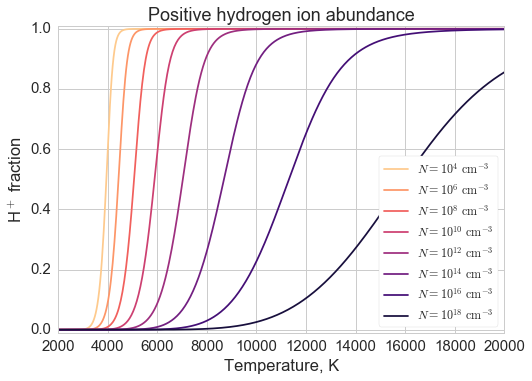

In [11]:
logNgrid = range(4, 20, 2)
Tgrid = np.linspace(2e3, 2e4, 500)
fig, ax = plt.subplots(1, 1)
legend_box_params = {
  'frameon': True,
  'fancybox': True,
  'fontsize': 'large',
}
colors = sns.color_palette('magma_r', n_colors=len(logNgrid))
epsilon = 0.01
for logN, c in zip(logNgrid, colors):
  ax.plot(Tgrid, Hplus_fraction(10**logN, Tgrid), color=c, 
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_ylim(-epsilon, 1 + epsilon)
ax.set_title('Positive hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^+$ fraction');

At the lower densities, hydrogen transitions from almost fully neutral to almost fully ionized over a narrow range of temperatures around 4000 K.  But such low densities are only seen in the corona, where LTE does not apply.   As the density is increased, higher temperatures are required and the curves shift to the right.  For densities characteristic of stellar photospheres, the transition occurs around 7000 to 10,000 K.

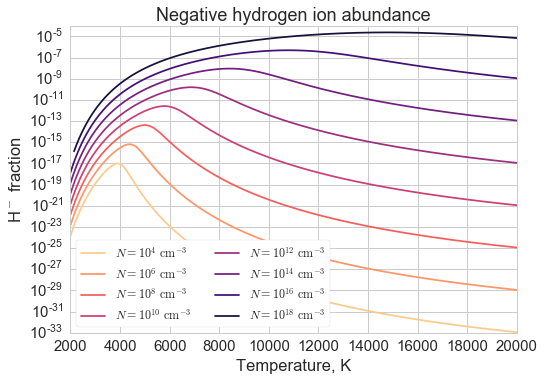

In [12]:
fig, ax = plt.subplots(1, 1)
for logN, c in zip(logNgrid, colors):
  ax.semilogy(Tgrid, Hminus_fraction(10**logN, Tgrid), color=c,
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower left', ncol=2, **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_title('Negative hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^-$ fraction');

The abundance of negative hydrogen ion is shown on a logarithmic scale.  It generally increases with density, and it has a peak at the temperature where H is about 50% ionized, as can be seen by comparing this graph with the previous one.

## Excitation of bound levels of H⁰

We use the Boltzmann equation to calculate the fractional population of a given bound level, $n$, of neutral hydrogen.  
$$
\frac{N_n}{N_{H^0}} = \frac{g_n}{U(T)} e^{-E_n/k T}
$$
where the degeneracy is $g_n = 2 n^2$ and the energy in Rydbergs above the ground ($n=1$) level is $E_n = 1 - n^{-2}$.

Here is the function to do that:

In [13]:
def H0_level_population(n, T, U=2.0):
    """
    Calcular la población ETL del nivel n de hidrógeno neutro
    a una temperatura T kelvin
    """
    # Energía de excitación respeto a n=1
    E = RYDBERG * (1.0 - 1.0/n**2)
    # Peso estadístico
    g = 2.0*n**2
    return (g/U)*np.exp(-E/(BOLTZMANN*T))


**[Extra credit: not required for tarea]**

At low temperatures, the population of excited levels is negligible and we can take $U(T) \approx g_1 = 2$.  But, in general we need to evaluate the partition function as
$$
U(T) = \sum_1^{n_\mathrm{max}}\ g_n\ e^{-E_n/k T}
$$
We can calculate this by re-using the `H0_level_population` function:

In [14]:
def H0_partition_function(T, nmax):
  U = 0.0
  for n in range(1, nmax+1):
    U += H0_level_population(n, T, U=1.0)
  return U

We cannot take $n_\mathrm{max} \to \infty$ in this func, since the sum diverges.  It is therefore important to find a physically motivated argument for determining the highest bound level, $n_\mathrm{max}$.

Taking account of the *pressure ionization* due to perturbations from neighboring particles, we make the approximation that in order that a level $n$ should be bound, the radius of the level, $r_n$, must be less than the average distance between particles: $\sim (N_H)^{-1/3}$.  Using $r_n = n^2 a_0$, where $a_0$ is the Bohr radius, this gives a maximum bound level $n_\mathrm{max} = a_0^{-1/2} N_H^{-1/6}$.  See Hubeny & Mihalas, Chapter 4, p. 91 for more details.


In [15]:
def nmax_pressure_ionization(Hden):
  """
  Calcular el nivel máximo ligado de H, sujeto a perturbaciones 
  por vecinos con densidad `Hden`
  """
  return 1./np.sqrt(BOHR_RADIUS*Hden**(1./3.))

Now we use the above function to make a table of $n_\mathrm{max}$ for different densities.  It is typicially $\sim 100$ for photospheric densities.  At the higher densities found in stellar interiors ($N_H > 10^{21}\ \mathrm{cm}^{-3}$) even the $n = 1$ level becomes unbound and H is fully ionized at all temperatures.

In [16]:
Ns = (10**np.array(logNgrid, dtype='float'))*u.cm**-3
Table(data=[
  Column(Ns, 
        name=r'Hydrogen density, $N_H$', format='{:.0e}'),
  Column(nmax_pressure_ionization(Ns.value).astype(int), 
        name=r'Maximum bound level, $n_\mathrm{max}$')])

"Hydrogen density, $N_H$","Maximum bound level, $n_\mathrm{max}$"
1 / cm3,
float64,int64
1e+04,2961
1e+06,1374
1e+08,638
1e+10,296
1e+12,137
1e+14,63
1e+16,29
1e+18,13


Finally, we can return to the partition function, plotting it against $T$ using the $n_\mathrm{max}$ appropriate to different densities. For each density, the curves are only plotted for $T$ where the neutral hydrogen fraction, $1 - y$, is larger than $10^{-6}$.  We also show with symbols the points where the ionization fraction is $y = 0.95$ (squares) and $y = 0.999$ (circles).

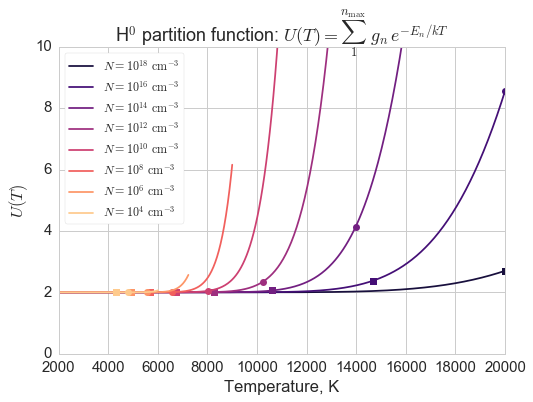

In [17]:
fig, ax = plt.subplots(1, 1)
for Hden, c in zip(Ns.value[::-1], colors[::-1]):
  nmax = int(nmax_pressure_ionization(Hden))
  Ugrid = H0_partition_function(Tgrid, nmax=nmax)
  mask = 1.0 - Hplus_fraction(Hden, Tgrid) > 1.e-6
  ax.plot(Tgrid[mask], Ugrid[mask], color=c,
         label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(int(np.log10(Hden))))
  for y, sym in [0.95, 's'], [0.999, 'o']:
    i0 = np.argmin(np.abs(Hplus_fraction(Hden, Tgrid) - y)) 
    ax.plot(Tgrid[i0], Ugrid[i0], sym, color=c)
ax.set_ylim(None, 10.)
frame = ax.legend(loc='upper left', **legend_box_params).get_frame()
frame.set_facecolor('white')
sigmatext = r'$U(T) = \sum_1^{n_\mathrm{max}}\ g_n\, e^{-E_n/k T}$'
ax.set_title('H$^0$ partition function: ' + sigmatext)
ax.set_xlabel('Temperature, K')
ax.set_ylabel(r'$U(T)$');        

It can be seen that $U(T)$ only rises above $2$ for densities above $10^8\ \mathrm{cm}^{-3}$, and that it only becomes large when the hydrogen is nearly completely ionized ($y \gtrapprox 0.999$). 

In the function `Hplus_fraction` above, we calculated the hydrogen ionization fraction under the approximation that $U(T) = 2$.  We will now redo this function, but using the better approximation to $U(T)$ that we have just found.

For consistency, we should also incorporate the *continuum lowering* effect in the ionization balance.  It can be included in a simple way by reducing the H⁰ ionization potential. However, once the ground level becomes unbound, then the approximations that we are using are no longer valid, so we should not expect this to be accurate for very large densities. 

In [18]:
@np.vectorize
def Hplus_fraction_U(Hden, T):
    """
    Calcular fracción de hidrógeno ionizado con un U(T) más realista
   	
   	`Hden` es densidad de partículas totales de H en cm^{-3}
    `T` es temperatura en K
    """
    nmax = nmax_pressure_ionization(Hden)
    U = H0_partition_function(T, nmax=int(nmax))
    Ei = RYDBERG*(1.0 - 1.0/max(1.0, nmax**2))
    A = Saha_Phi(T, Eion=Ei, Un=U) / Hden
    # Resolver polinomio: y**2 + A*y - A = 0
    y = np.roots([1.0, A, -A])[1] # tomar raiz positivo
    return y

Now we compare the two approximations.  The constant-$U$ version is shown as a dashed line and the new version as a solid line.  We change to a logarithmic scale in temperature so we can see the effects of very large densities more clearly.

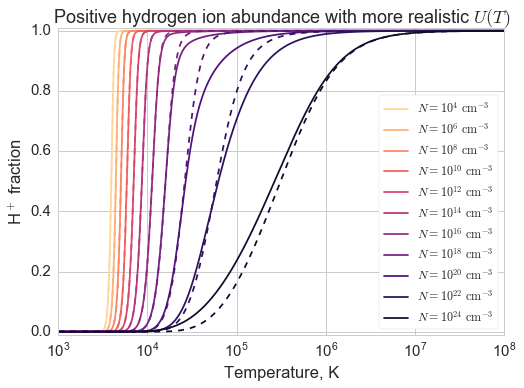

In [19]:
Tgrid_wide = np.logspace(3.0, 8.0, 500)
logNgrid_wide = range(4, 26, 2)
colors_wide = sns.color_palette('magma_r', n_colors=len(logNgrid_wide))
fig, ax = plt.subplots(1, 1)
for logN, c in zip(logNgrid_wide, colors_wide):
  Hden = 10**logN
  ax.plot(Tgrid_wide, Hplus_fraction_U(Hden, Tgrid_wide), color=c, 
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
  ax.plot(Tgrid_wide, Hplus_fraction(Hden, Tgrid_wide), '--', color=c, 
          label=None)
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_ylim(-epsilon, 1 + epsilon)
ax.set_xscale('log')
ax.set_title('Positive hydrogen ion abundance with more realistic $U(T)$')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^+$ fraction');

At moderate densities of $10^{16}$ to $10^{20}\ \mathrm{cm}^{-3}$ the prinicipal effect is to increase the neutral fraction at temperatures where H is nearly fully ionized.  At the very highest densities $ > 10^{22}\ \mathrm{cm}^{-3}$, the continuum lowering starts to dominate and the partial ionization extends to lower temperatures. 

## Wavelength-dependent cross sections

### Neutral hydrogen H⁰

#### Bound-free photoionization cross sections

For photoionization from level $n$, there is a threshold energy, $E_n = n^{-2}\ \mathrm{Ry}$, with a corresponding minimum frequency, $\nu_n = E_n/h$, or maximum wavelength, $\lambda_n = h c / E_n$.  The cross section is given by
$$
\sigma_\mathrm{bf}(n, \nu) = \sigma_0 n \frac{\nu_n^3}{\nu^3} g_\mathrm{bf}(n, \nu)
$$
where $\sigma_0 = 2.815\times 10^{29} \nu_1^{-3} =  7.906 \times 10^{-18}\ \mathrm{cm}^2$ and $g_\mathrm{bf}(n, \nu)$ is the Gaunt factor that corrects for quantum mechanical effects.  

In [20]:
@np.vectorize
def xsec_H0_boundfree(n, nu, xsec0=7.906e-18):
    """
    Sección eficaz de fotoionización de nivel n de H0 a frecuencia nu Hz

    Multiplicar por densidad de H0(n) para dar coeficiente de absorción (cm^{-1})
    """
    E = PLANCK*nu               # energía de fotón
    E0 = RYDBERG/n**2           # energía de ionización de nivel n

    if E >= E0:
        xsec = gaunt_H0_boundfree(n, nu)*xsec0*n*(E0/E)**3
    else:
        xsec = 0.0

    return xsec


For the gaunt factor we use the Menzel & Perkis approximation given in Gray's Eq (8.5):
$$
g_\mathrm{bf}(n, \nu) = 1 - \frac{0.3456}{(\lambda R)^{1/3}} 
\left( \frac{\lambda R}{n^2} - \frac{1}{2}\right) .
$$

In [21]:
def gaunt_H0_boundfree(n, nu):
  """
  Factor Gaunt para fotoionización de nivel `n` de H0 a frecuencia `nu` Hz
  """
  lambda_R = RYDBERG/(PLANCK*nu)
  return 1.0 - 0.3456*(lambda_R/n**2 - 0.5)/lambda_R**(1./3.)

Define an array of wavelengths for plotting and calculate the corresponding frequencies. 

In [22]:
wavs = np.linspace(40.0, 20000.0, 500)*u.AA
freqs = (light_speed/wavs).cgs
freqs[[0, -1]]

<Quantity [  7.49481145e+16,  1.49896229e+14] 1 / s>

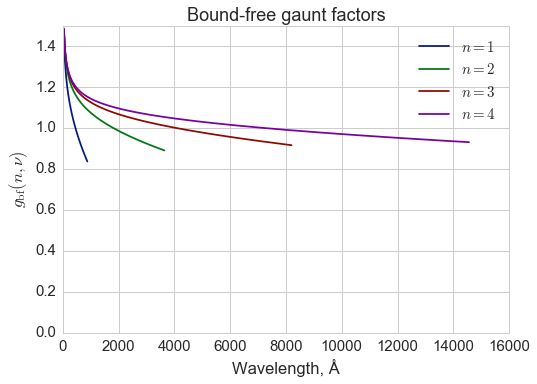

In [23]:
fig, ax = plt.subplots(1, 1)
for n in range(1, 5):
  m = h*freqs >= 1.0*u.Ry/n**2
  ax.plot(wavs[m], gaunt_H0_boundfree(n, freqs.value[m]), 
         label=r'$n = {}$'.format(n))
ax.set_ylim(0.0, None)
ax.legend()
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$g_\mathrm{bf}(n, \nu)$')
ax.set_title('Bound-free gaunt factors');

The gaunt factors are of order unity, tending to increase slightly in the ultraviolet.  For each $n$, it only makes sense to plot them for $\lambda < \lambda_n$. 

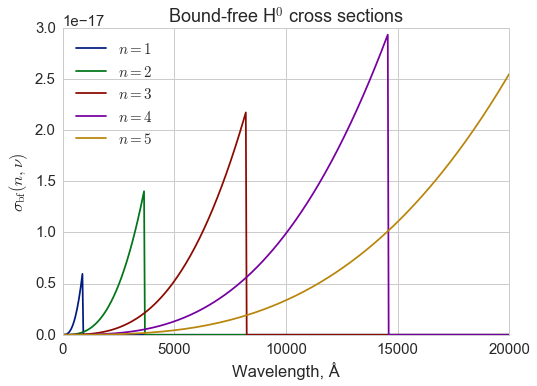

In [24]:
fig, ax = plt.subplots(1, 1)
for n in range(1, 6):
  ax.plot(wavs, xsec_H0_boundfree(n, freqs.value), 
         label=r'$n = {}$'.format(n))
ax.set_ylim(0.0, None)
ax.legend(loc='upper left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{bf}(n, \nu)$')
ax.set_title('Bound-free H$^0$ cross sections');

The cross sections can be compared with Gray's Fig 8.2.

### Free-free H⁰ cross-sections


The cross section per electron (see Rybicki, section 5.3) can be written as 
$$
\alpha_\mathrm{ff} = \alpha_0 \frac{g_\mathrm{ff}(T, \nu)}{\nu^3 T^{1/2}} \quad \mathrm{cm^2\ \big/\ e^-}, 
$$
where 
$$
\alpha_0 = \frac{4 e^6}{3 m h c} \left(\frac{2\pi}{3 k m}\right)^{1/2} , 
$$
and the free-free Gaunt factor can be approximated (Gray, Eq. 8.6) as 
$$
g_\mathrm{ff}(T, \nu) = 1 - \frac{0.3456}{(\lambda R)^{1/3}} 
\left( \frac{k T}{h \nu} + \frac{1}{2}\right) .
$$
We calculate the numerical value of the constant, $\alpha_0$:

In [25]:
from astropy.constants import e, m_e
alpha0 = np.sqrt(2*np.pi/(3*k_B*m_e))*(4*e.esu**6)/(3*m_e*h*light_speed)
alpha0.cgs

<Quantity 369234922.4548029 cm5 K(1/2) / s3>

In [26]:
def xsec_H0_freefree(T, nu):
    """
    Sección eficaz por electrón de bremsstrahlung a frecuencia nu Hz

    Multiplicar por Ne N(H+) para dar coeficiente de absorción (cm^{-1})
    """
    return alpha0.cgs.value * gaunt_H0_freefree(T, nu) * T**-1.5 / nu**2 # Rybicki, eq. 5.19b

In [27]:
def gaunt_H0_freefree(T, nu):
  """
  Factor Gaunt para absorción libre-libre H0 a frecuencia `nu` Hz
  """
  lambda_R = RYDBERG/(PLANCK*nu)
  return 1.0 - 0.3456*(BOLTZMANN*T/(PLANCK*nu) + 0.5)/lambda_R**(1./3.)

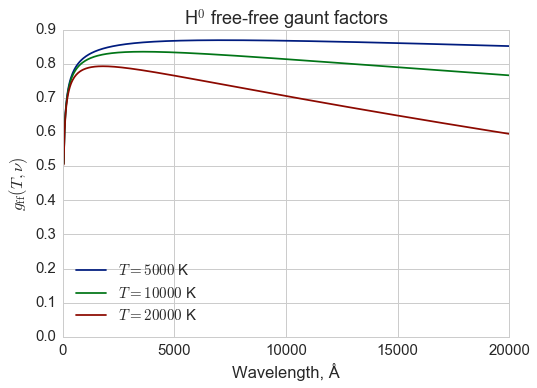

In [28]:
fig, ax = plt.subplots(1, 1)
for T in [5e3, 1e4, 2e4]:
  ax.plot(wavs, gaunt_H0_freefree(T, freqs.value), 
         label=r'$T = {:.0f}$ K'.format(T))
ax.set_ylim(0.0, None)
ax.legend(loc='lower left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$g_\mathrm{ff}(T, \nu)$')
ax.set_title('H$^0$ free-free gaunt factors');

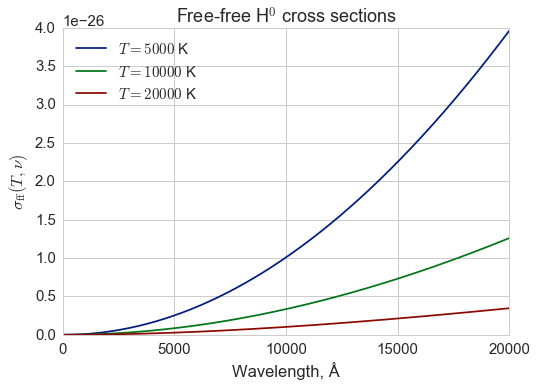

In [29]:
fig, ax = plt.subplots(1, 1)
for T in [5e3, 1e4, 2e4]:
  ax.plot(wavs, xsec_H0_freefree(T, freqs.value), 
         label=r'$T = {:.0f}$ K'.format(T))
ax.set_ylim(0.0, None)
ax.legend(loc='upper left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{ff}(T, \nu)$')
ax.set_title('Free-free H$^0$ cross sections');

### Negative hydrogen ion H⁻

#### Bound-free H⁻ cross section

We use the polynomial fit from Gray, which is stated to be accurate in the range $2250~Å < \lambda < 15,000~Å$.  This gives the cross section in $\mathrm{cm}^2$, so it needs to be multiplied by $N_{H^-}$. 

In [40]:
@np.vectorize
def xsec_Hminus_boundfree(nu):
    """
    Sección eficaz de fotoionización del ión negativo H- a frecuencia nu Hz

    Multiplicar por N(H-) para dar coeficiente de absorción (cm^{-1})
    """
    # convertir nu a lambda en unidades de micras (10,000 Å)
    wav = (light_speed / (nu * u.Hz)).to(u.micron).value  
    # Fórmula y constantes de Gray, Eq. 8.11
    A = [1.99654, -1.18267e-1, 2.64243e2, 
         -4.40524e2, 3.23992e2, -1.39568e2, 2.78701e1]
    xsec = 0.0
    # El ajuste es preciso para 2250 Å <= lambda <= 15,000 Å 
    # Hay que cortarlo a partir de 16,200 Å porque el ajuste va negativo
    for i, a in enumerate(A):
        if wav <= 1.62:
            xsec += a*wav**i
    return xsec * 1.e-18

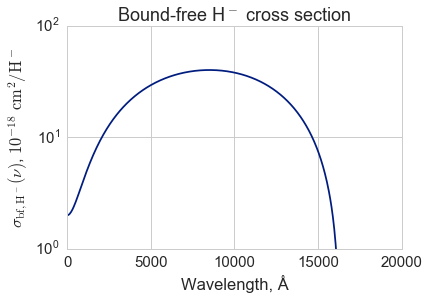

In [70]:
fig, ax = plt.subplots(1, 1)
ax.plot(wavs, xsec_Hminus_boundfree(freqs.value)/1e-18, 
         label=r'bf')
ax.set_ylim(0.0, 5e-17)
#ax.legend(loc='lower center')
ax.set_yscale('log')
ax.set_ylim(1.0, 100.0)
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{bf,H^-}(\nu)$, $10^{-18}\ \mathrm{cm}^2 / \mathrm{H}^-$')
ax.set_title('Bound-free H$^-$ cross section');

The graph above bears a reasonable resemblance to Gray's Fig. 8.3

#### Free-free H⁻ opacity

This is also calculated from polynomial fits given by Gray, which accurately reproduce the results of Bell & Berrington (1987) for the range $1823~Å < \lambda < 151,890~Å$ and $1400~\mathrm{K} < T < 10,080~\mathrm{K}$.

In [55]:
def Hz_to_AA(nu):
  """
  Utility function to translate frequency to wavelength
  """
  return (light_speed / (nu / u.s)).to(u.AA).value

@np.vectorize
def xsec_Hminus_freefree(T, nu):
    """
    Opacidad libre-libre del ión negativo H- a frecuencia nu Hz

    Multiplicar por Pe N(H0) para dar coeficiente de absorción (cm^{-1})
    + Ojo que no hay que multiplicar por N(H-)
    + Y esto ya incluye la correción por emisión estimulada
    """
    # convertir nu a lambda en unidades de Å
    wav = Hz_to_AA(nu)  
    logwav = np.log10(wav)
    # Eq. 8.13 de Gray
    f0 = -2.2763 - 1.6850*logwav + 0.76661*logwav**2 - 0.053346*logwav**3
    f1 = 15.2827 - 9.2846*logwav + 1.99381*logwav**2 - 0.142631*logwav**3
    f2 = (-197.789 + 190.266*logwav 
          - 67.9775*logwav**2 + 10.6913*logwav**3 - 0.625151*logwav**4)
    theta = np.log10(np.e) / (BOLTZMANN*T) # aproximadamente theta = 5040/T
    xsec = 1.e-26 * 10**(f0 + f1*np.log10(theta) + f2*np.log10(theta)**2)
    return xsec

The free free opacity is more important at longer wavelengths, so we define an extended range of wavelengths for plotting, up to just over $10~µm$. 

In [65]:
wavs_extend = np.logspace(3.1, 5.1, 500)*u.AA
freqs_extend = (light_speed/wavs_extend).cgs

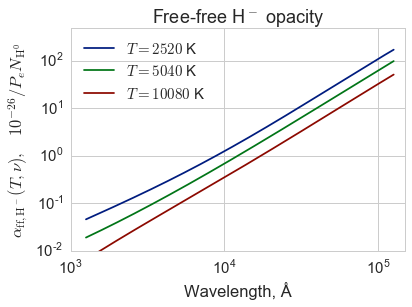

In [71]:
fig, ax = plt.subplots(1, 1)
for T in [2520.0, 5040.0, 10080.0]:
  ax.plot(wavs_extend, xsec_Hminus_freefree(T, freqs_extend.value)/1e-26, 
         label=r'$T = {:.0f}$ K'.format(T))
ax.plot()
ax.set_ylim(0.01, 500)
ax.set_xlim(1000.0, 150000.0)
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\alpha_\mathrm{ff,H^-}(T, \nu),\quad 10^{-26}/ P_e N_\mathrm{H^0}$ ')
ax.set_title('Free-free H$^-$ opacity');

This graph closely resemble Gray's Fig. 8.4.  Note that the fits already include the correction for stimulated emission and are per neutral H atom and per unit electron pressure.